# Google Authentication to import files from Buckets

In [ ]:
from google.colab import auth
from google.cloud import storage

# Autentifikace
auth.authenticate_user()

# Nastavení Google Cloud projektu
project_id = "pef-kit-masner-studenti-402913"
!gcloud config set project {project_id}

Updated property [core/project].


In [ ]:
import os

# Vytvoření složky pro připojení bucketu
if "Bucket" not in os.listdir("."):
    !mkdir Bucket

bucket_dir = "/content/Bucket/"

In [ ]:
# Instalace potřebných knihoven
!echo "deb https://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse=1.4.0

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100  2659  100  2659    0     0  42094      0 --:--:-- --:--:-- --:--:-- 42206
OK
63 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: https://packages.cloud.google.com/apt/dists/gcsfuse-bionic/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
gcsfuse is already the newest version (1.4.0).
0 upgraded, 0 newly installed, 0 to remove and 62 not upgraded.


In [ ]:
# Připojení bucketu do notebooku
!gcsfuse --implicit-dirs emergence224 ./Bucket

{"time":"07/04/2024 10:05:16.218359","severity":"INFO","msg":"Start gcsfuse/1.4.0 (Go version go1.21.5) for app \"\" using mount point: /content/Bucket\n"}


# Notebook dependencies

In [ ]:
# Instalace potřebných knihoven
!pip install keras-tcn
!pip install keras-tuner

In [ ]:
# Nastavení cest
# Hlavní složka (pokud chcete spouště kód v Colabu, stačí změnit cestu na "/content/drive/Shareddrives/KIT ML 2")
main_dir = bucket_dir + "Fenotypizace/"

# Složka se všemi daty
data_path = main_dir + "Data/"

# Složka s modely
model_path = data_path + "Models/"

# Samples path
data_images_path = data_path + "numpy/cropped64/"

# Vybrání sadbovačů pro trénování, validaci a testováné
trays_train = [10, 11, 12, 13, 14, 15, 16, 18, 41, 47]
trays_val = [17, 40, 42, 44, 45]
trays_test = [43, 46, 48]

# Image parametrs
height, width, colors = 64, 64, 3

# Step, we need to identify precisely the time when it emerges
slide_step = 1

# Model hyperparametrs
num_epochs = 300
learning_rate = 0.00005

In [ ]:
# Main libraries
import tensorflow as tf
import keras_tuner as kt
import numpy as np
import keras.backend as k_backend
import gc

# Individual functions
from tcn import TCN
from matplotlib import pyplot as plt
from tensorflow import keras

from keras.layers import Input, Lambda, Dense, LSTM, Rescaling
from keras.models import Sequential
from keras import Input, Model
from keras.callbacks import EarlyStopping
from keras.applications.efficientnet_v2 import EfficientNetV2B0

# Functions

## General

In [ ]:
def visualize_training(model_history):
  plt.figure(figsize=(30, 10))
  plt.plot(np.array(model_history.history["loss"]), "r--", label="Train loss")
  plt.plot(np.array(model_history.history["accuracy"]), "g--", label="Train accuracy")
  plt.plot(np.array(model_history.history["val_loss"]), "r-", label="Validation loss")
  plt.plot(
      np.array(model_history.history["val_accuracy"]),
      "g-",
      label="Validation accuracy",
  )
  plt.title("Training session's progress over iterations")
  plt.legend(loc="upper right")
  plt.ylabel("Training Progress (Loss/Accuracy)")
  plt.xlabel("Training Epoch")
  plt.ylim(0)
  plt.show()

In [ ]:
def save_model(dir_name, model_name):
  directory = model_path + dir_name

  # Kontrola, zda složka již existuje
  if not os.path.exists(directory):
      os.makedirs(directory)

  model_name.save(directory)
  print(f"Model: {dir_name} was saved.")

In [ ]:
def load_data_npy(base_path, time_step, size, use_trays):
  train_sample = np.load(f"{base_path}data_64_{time_step}_{size}_{use_trays}.npy")
  annotation_sample = np.load(f"{base_path}annotations_64_{time_step}_{size}_{use_trays}.npy")
  # height, width = train_sample .shape[2], train_sample .shape[3]

  # Check if samples are the same
  unique_values, counts = np.unique(annotation_sample, return_counts=True)
  print(f"Data has shape: {train_sample.shape} with annotations: {annotation_sample.shape}")
  print(f"Unique annotation values: {unique_values} with counts: {counts}\n")

  return train_sample, annotation_sample

In [ ]:
def evaluate_model(time_step, size, model_name, path = None):
  # Load the test data and annotations
  x_test, y_test = load_data_npy(
    base_path=data_images_path, time_step=time_step, use_trays=trays_test, size=size
  )

  if path is None:
    # Load the saved model
    loaded_model = model_name
  else:
    loaded_model = tf.keras.models.load_model(path + model_name)

  # Perform evaluation on the test data
  evaluation = loaded_model.evaluate(x_test, y_test)

  # Print the evaluation metrics
  print("Evaluation Loss:", evaluation[0])
  print("Evaluation Accuracy:", evaluation[1])

In [ ]:
def create_callbacks(mode):
  if mode == "tuner":
    return tf.keras.callbacks.EarlyStopping(
      monitor="val_loss", mode="min", patience=3, restore_best_weights=True)
  else:
    return tf.keras.callbacks.EarlyStopping(
      monitor="val_loss", mode="min", patience=10, restore_best_weights=True)

## Tunner functions

In [ ]:
def tcn_layer_tuner(hp):
  nb_filters = hp.Int("nb_filters", min_value=4, max_value=30, step=2)
  kernel_size = hp.Choice("kernel_size", values=[2, 3, 4, 5, 6])
  dropout_rate = hp.Float("dropout_rate", min_value=0.0, max_value=0.05, step=0.01)
  nb_stacks = hp.Int("nb_stacks", min_value=1, max_value=2, step=1)

  return TCN(
    nb_filters=nb_filters,
    kernel_size=kernel_size,
    nb_stacks=nb_stacks,
    dilations=(1, 2, 4),
    padding="causal",
    use_skip_connections=True,
    dropout_rate=dropout_rate,
    return_sequences=False,
    activation="sigmoid",
    kernel_initializer="he_normal",
    use_batch_norm=False,
    use_layer_norm=False,
    use_weight_norm=False,
    )

In [ ]:
def lstm_layer_tuner(hp):
  units = hp.Choice("lstm_units", values=[32, 64, 128, 256, 512])
  return LSTM(units, return_sequences=False)

In [ ]:
def define_model_efficientnet_b0(hp, time_steps, h, w, c, tuner_type):
  if tuner_type == "tcn_tuner":
    time_layer = tcn_layer_tuner(hp)
  elif tuner_type == "lstm_tuner":
    time_layer = lstm_layer_tuner(hp)
  else:
    time_layer = tcn_layer()

  shape = (time_steps, h, w, c)
  inputs = Input(shape=shape)
  x = Rescaling(scale=1.0 / 255)(inputs)
  x = Lambda(lambda y: k_backend.reshape(y, (-1, h, w, c)))(x)  # (inputs) #(x)
  x = EfficientNetV2B0(input_shape=(w, h, c), include_top=False, weights="imagenet")(x)
  num_features_cnn = np.prod(k_backend.int_shape(x)[1:])
  x = Lambda(lambda y: k_backend.reshape(y, (-1, time_steps, num_features_cnn)))(x)
  x = time_layer(x)
  x = Dense(1, activation="sigmoid")(x)

  return Model(inputs=[inputs], outputs=[x])


In [ ]:
def build_model(hp, tuner_type, time_step):
  model = define_model_efficientnet_b0(hp, time_step, height, width, colors, tuner_type)
  learning_rate = hp.Choice(
      "learning_rate", values=[0.001, 0.0005, 0.0001, 0.00001, 0.00005]
  )
  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
  model.compile(optimizer, loss="binary_crossentropy", metrics=["accuracy"])

  return model


In [ ]:
def create_tuner(tuner_type, time_step, size):
  if tuner_type == "tcn_tuner":
    project = f"keras_tuner_tcn_{time_step}-{size}"
  elif tuner_type == "lstm_tuner":
    project = f"keras_tuner_lstm_{time_step}-{size}"
  else:
    print("Zvolte korektní časovou vrstvu.")
    return None

  return kt.Hyperband(
    lambda hp: build_model(hp, tuner_type, time_step),
    objective="val_accuracy",
    max_epochs=10,
    factor=3,
    directory=f"{model_path}keras_tuner_dir",
    project_name=project
    )

## Original training

In [ ]:
def tcn_layer(activation="sigmoid"):
  return TCN(
    nb_filters=6,
    kernel_size=4,
    nb_stacks=1,
    dilations=(1, 2, 4),
    padding='causal',
    use_skip_connections=True,
    dropout_rate=0.01,
    return_sequences=False,
    activation=activation,
    kernel_initializer='he_normal',
    use_batch_norm=False,
    use_layer_norm=False,
    use_weight_norm=False,
  )

In [ ]:
def train_model(model, x_train, y_train, x_val, y_val, epochs=100, callbacks=None, learning_rate=0.000001):
  model.summary()
  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
  model.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])
  return model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), epochs=epochs, callbacks=callbacks)

# Model 3_9
- Size of the series: 3
- Images before/after emerged: 9

In [ ]:
time_step = 3
size = 9

data_train, annotations_train = load_data_npy(
  base_path=data_images_path, time_step=time_step, use_trays=trays_train, size=size
)

data_val, annotations_val = load_data_npy(
  base_path=data_images_path, time_step=time_step, use_trays=trays_val, size=size
)

Data has shape: (9824, 3, 64, 64, 3) with annotations: (9824,)
Unique annotation values: [0 1] with counts: [4914 4910]

Data has shape: (4933, 3, 64, 64, 3) with annotations: (4933,)
Unique annotation values: [0 1] with counts: [2471 2462]



## TCN

In [ ]:
tuner_tcn = create_tuner("tcn_tuner", time_step, size)

In [ ]:
tuner_tcn.search(
  data_train,
  annotations_train,
  epochs=10,
  validation_data=(data_val, annotations_val),
  callbacks=[create_callbacks("tuner")]
)

Trial 30 Complete [00h 04m 32s]
val_accuracy: 0.49908778071403503

Best val_accuracy So Far: 0.9704034328460693
Total elapsed time: 01h 17m 05s


In [ ]:
best_hps_tcn = tuner_tcn.get_best_hyperparameters(num_trials=1)[0]

best_hyperparameters_tcn = tuner_tcn.get_best_hyperparameters()[0]
print("Nejlepší hyperparametry:", best_hyperparameters_tcn.values)

Nejlepší hyperparametry: {'nb_filters': 28, 'kernel_size': 2, 'dropout_rate': 0.02, 'nb_stacks': 2, 'learning_rate': 5e-05, 'tuner/epochs': 4, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}


In [ ]:
model_tcn = tuner_tcn.hypermodel.build(best_hps_tcn)
model_tcn.summary()
history_tcn = model_tcn.fit(
  data_train,
  annotations_train,
  epochs=num_epochs,
  validation_data=(data_val, annotations_val),
  callbacks=[create_callbacks("train")]
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 3, 64, 64, 3)]    0         
                                                                 
 rescaling_2 (Rescaling)     (None, 3, 64, 64, 3)      0         
                                                                 
 lambda_2 (Lambda)           (None, 64, 64, 3)         0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 2, 2, 1280)        5919312   
 nal)                                                            
                                                                 
 lambda_3 (Lambda)           (None, 3, 5120)           0         
                                                                 
 tcn_1 (TCN)                 (None, 28)                447692    
                                                           

In [ ]:
visualize_training(history_tcn)

In [ ]:
save_model(f"ef_tnc_tuner_{time_step}-{size}", model_tcn)

Model: ef_tnc_tunner_3-9 was saved.


In [ ]:
evaluate_model(time_step, size, model_tcn)
# evaluate_model("3.9 - cropped 64x64 tuner tcn", model_path)

Data has shape: (14765, 3, 64, 64, 3) with annotations: (14765,)
Unique annotation values: [0 1] with counts: [8873 5892]

462/462 [==============================] - 12s 21ms/step - loss: 0.1161 - accuracy: 0.9705
Evaluation Loss: 0.1161232739686966
Evaluation Accuracy: 0.9704707264900208


## LSTM

In [ ]:
tuner_lstm = create_tuner("lstm_tuner", time_step, size)

Reloading Tuner from /content/Bucket/Fenotypizace/Data/Models/keras_tuner_dir/keras_tuner_lstm/tuner0.json


In [ ]:
tuner_lstm.search(
  data_train,
  annotations_train,
  epochs=10,
  validation_data=(data_val, annotations_val),
  callbacks=[create_callbacks("tuner")]
)

Trial 30 Complete [00h 05m 13s]
val_accuracy: 0.9545915126800537

Best val_accuracy So Far: 0.9679707884788513
Total elapsed time: 01h 13m 36s


In [ ]:
best_hps_lstm = tuner_lstm.get_best_hyperparameters(num_trials=1)[0]

best_hyperparameters_lstm = tuner_lstm.get_best_hyperparameters()[0]
print("Nejlepší hyperparametry:", best_hyperparameters_lstm.values)

Nejlepší hyperparametry: {'lstm_units': 32, 'learning_rate': 5e-05, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0014'}


In [ ]:
model_lstm = tuner_lstm.hypermodel.build(best_hps_lstm)
model_lstm.summary()
history_lstm = model_lstm.fit(
  data_train,
  annotations_train,
  epochs=num_epochs,
  validation_data=(data_val, annotations_val),
  callbacks=[create_callbacks("train")]
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 3, 64, 64, 3)]    0         
                                                                 
 rescaling_2 (Rescaling)     (None, 3, 64, 64, 3)      0         
                                                                 
 lambda_2 (Lambda)           (None, 64, 64, 3)         0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 2, 2, 1280)        5919312   
 nal)                                                            
                                                                 
 lambda_3 (Lambda)           (None, 3, 5120)           0         
                                                                 
 lstm (LSTM)                 (None, 32)                659584    
                                                           

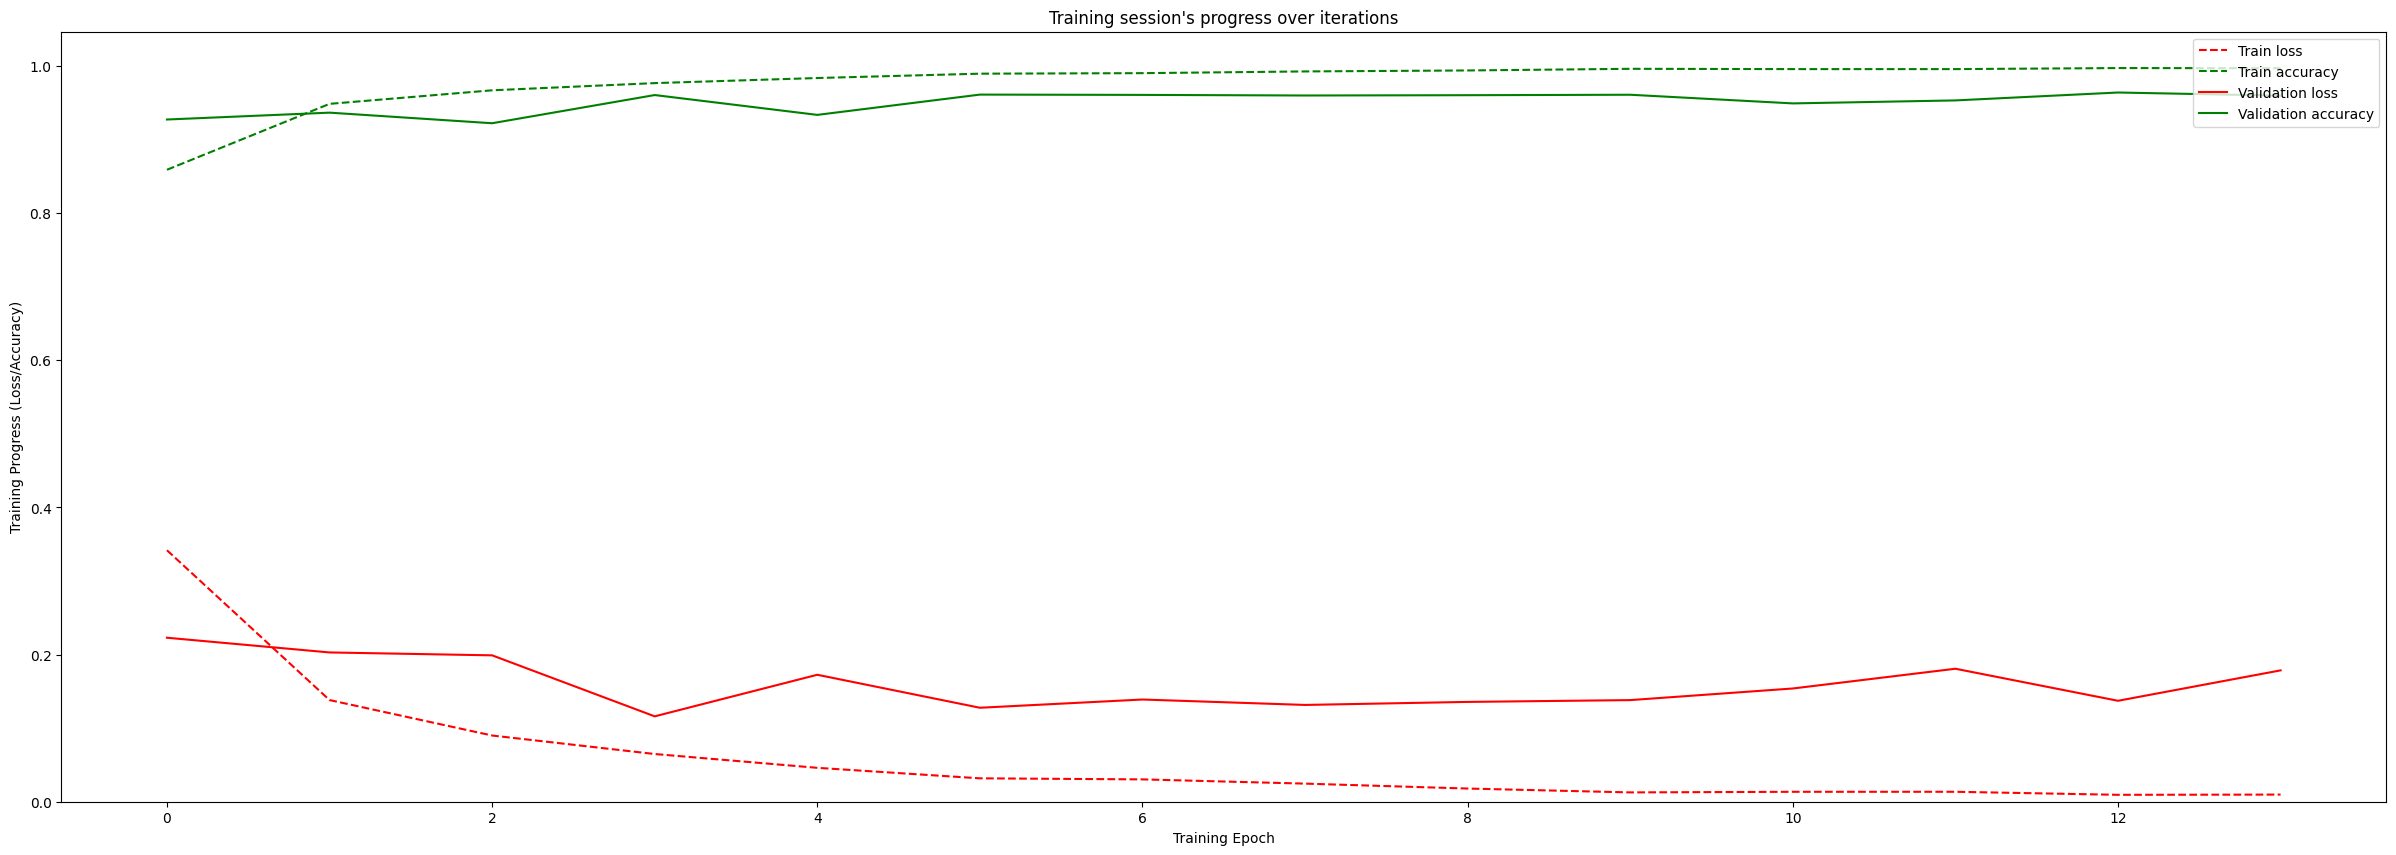

In [ ]:
visualize_training(history_lstm)

In [ ]:
save_model(f"ef_lstm_tuner_{time_step}-{size}", model_lstm)

Model: ef_lstm_tunner_3-9 was saved.


In [ ]:
evaluate_model(time_step, size, model_lstm)
# evaluate_model("3.9 - cropped 64x64 tuner lstm", model_path)

Data has shape: (14765, 3, 64, 64, 3) with annotations: (14765,)
Unique annotation values: [0 1] with counts: [8873 5892]

462/462 [==============================] - 12s 20ms/step - loss: 0.1846 - accuracy: 0.9388
Evaluation Loss: 0.18460336327552795
Evaluation Accuracy: 0.9387741088867188


## Original model

In [ ]:
model_orig = define_model_efficientnet_b0(hp=None, time_steps=time_step, h=height, w=width, c=colors, tuner_type=None)
history_orig = train_model(model_orig, x_train=data_train, y_train=annotations_train,
                      x_val=data_val, y_val=annotations_val, epochs=num_epochs,
                      callbacks=[create_callbacks("train")], learning_rate=learning_rate
                      )

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 64, 64, 3)]    0         
                                                                 
 rescaling (Rescaling)       (None, 3, 64, 64, 3)      0         
                                                                 
 lambda (Lambda)             (None, 64, 64, 3)         0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 2, 2, 1280)        5919312   
 nal)                                                            
                                                                 
 lambda_1 (Lambda)           (None, 3, 5120)           0         
                                                                 
 tcn (TCN)                   (None, 6)                 154362    
                                                             

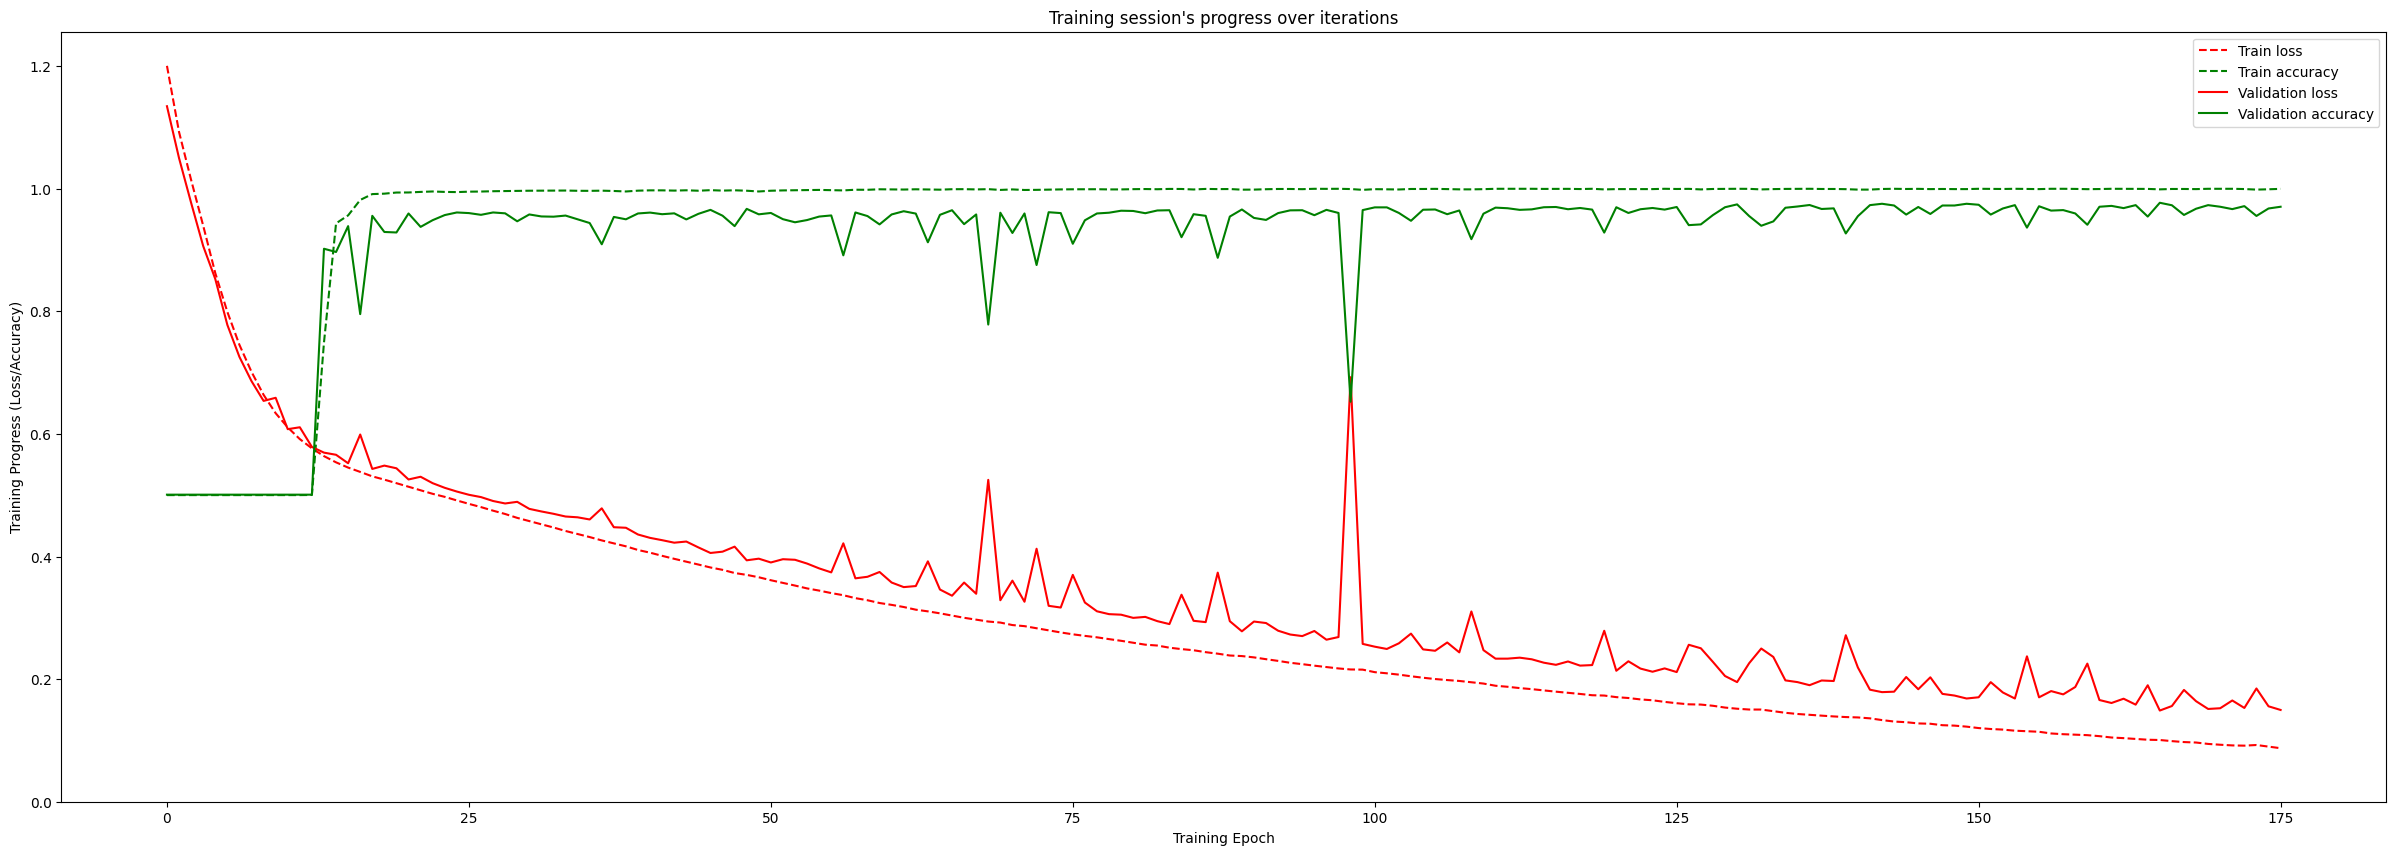

In [ ]:
visualize_training(history_orig)

In [ ]:
save_model(f"ef_tnc_{time_step}-{size}", model_orig)

Model: ef_tnc_3-9 was saved.


In [ ]:
evaluate_model(time_step, size, model_orig)
# evaluate_model("3.9 - EfficientNetB0v2 cropped 64", model_path)

Data has shape: (14765, 3, 64, 64, 3) with annotations: (14765,)
Unique annotation values: [0 1] with counts: [8873 5892]

462/462 [==============================] - 13s 23ms/step - loss: 0.1642 - accuracy: 0.9596
Evaluation Loss: 0.1642136126756668
Evaluation Accuracy: 0.9595665335655212


# Model 4_10
- Size of the series: 4
- Images before/after emerged: 10

In [ ]:
time_step = 4
size = 10

data_train, annotations_train = load_data_npy(
  base_path=data_images_path, time_step=time_step, use_trays=trays_train, size=size
)

data_val, annotations_val = load_data_npy(
  base_path=data_images_path, time_step=time_step, use_trays=trays_val, size=size
)

Data has shape: (9823, 4, 64, 64, 3) with annotations: (9823,)
Unique annotation values: [0 1] with counts: [4914 4909]

Data has shape: (4930, 4, 64, 64, 3) with annotations: (4930,)
Unique annotation values: [0 1] with counts: [2471 2459]



## TCN

In [ ]:
tuner_tcn = create_tuner("tcn_tuner", time_step, size)

In [ ]:
tuner_tcn.search(
  data_train,
  annotations_train,
  epochs=10,
  validation_data=(data_val, annotations_val),
  callbacks=[create_callbacks("tuner")]
)

Trial 30 Complete [00h 04m 16s]
val_accuracy: 0.8322515487670898

Best val_accuracy So Far: 0.9807302355766296
Total elapsed time: 01h 27m 00s


In [ ]:
best_hps_tcn = tuner_tcn.get_best_hyperparameters(num_trials=1)[0]

best_hyperparameters_tcn = tuner_tcn.get_best_hyperparameters()[0]
print("Nejlepší hyperparametry:", best_hyperparameters_tcn.values)

Nejlepší hyperparametry: {'nb_filters': 10, 'kernel_size': 2, 'dropout_rate': 0.0, 'nb_stacks': 2, 'learning_rate': 0.0001, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0020'}


In [ ]:
model_tcn = tuner_tcn.hypermodel.build(best_hps_tcn)
model_tcn.summary()
history_tcn = model_tcn.fit(
  data_train,
  annotations_train,
  epochs=num_epochs,
  validation_data=(data_val, annotations_val),
  callbacks=[create_callbacks("train")]
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 4, 64, 64, 3)]    0         
                                                                 
 rescaling_2 (Rescaling)     (None, 4, 64, 64, 3)      0         
                                                                 
 lambda_2 (Lambda)           (None, 64, 64, 3)         0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 2, 2, 1280)        5919312   
 nal)                                                            
                                                                 
 lambda_3 (Lambda)           (None, 4, 5120)           0         
                                                                 
 tcn_1 (TCN)                 (None, 10)                155930    
                                                           

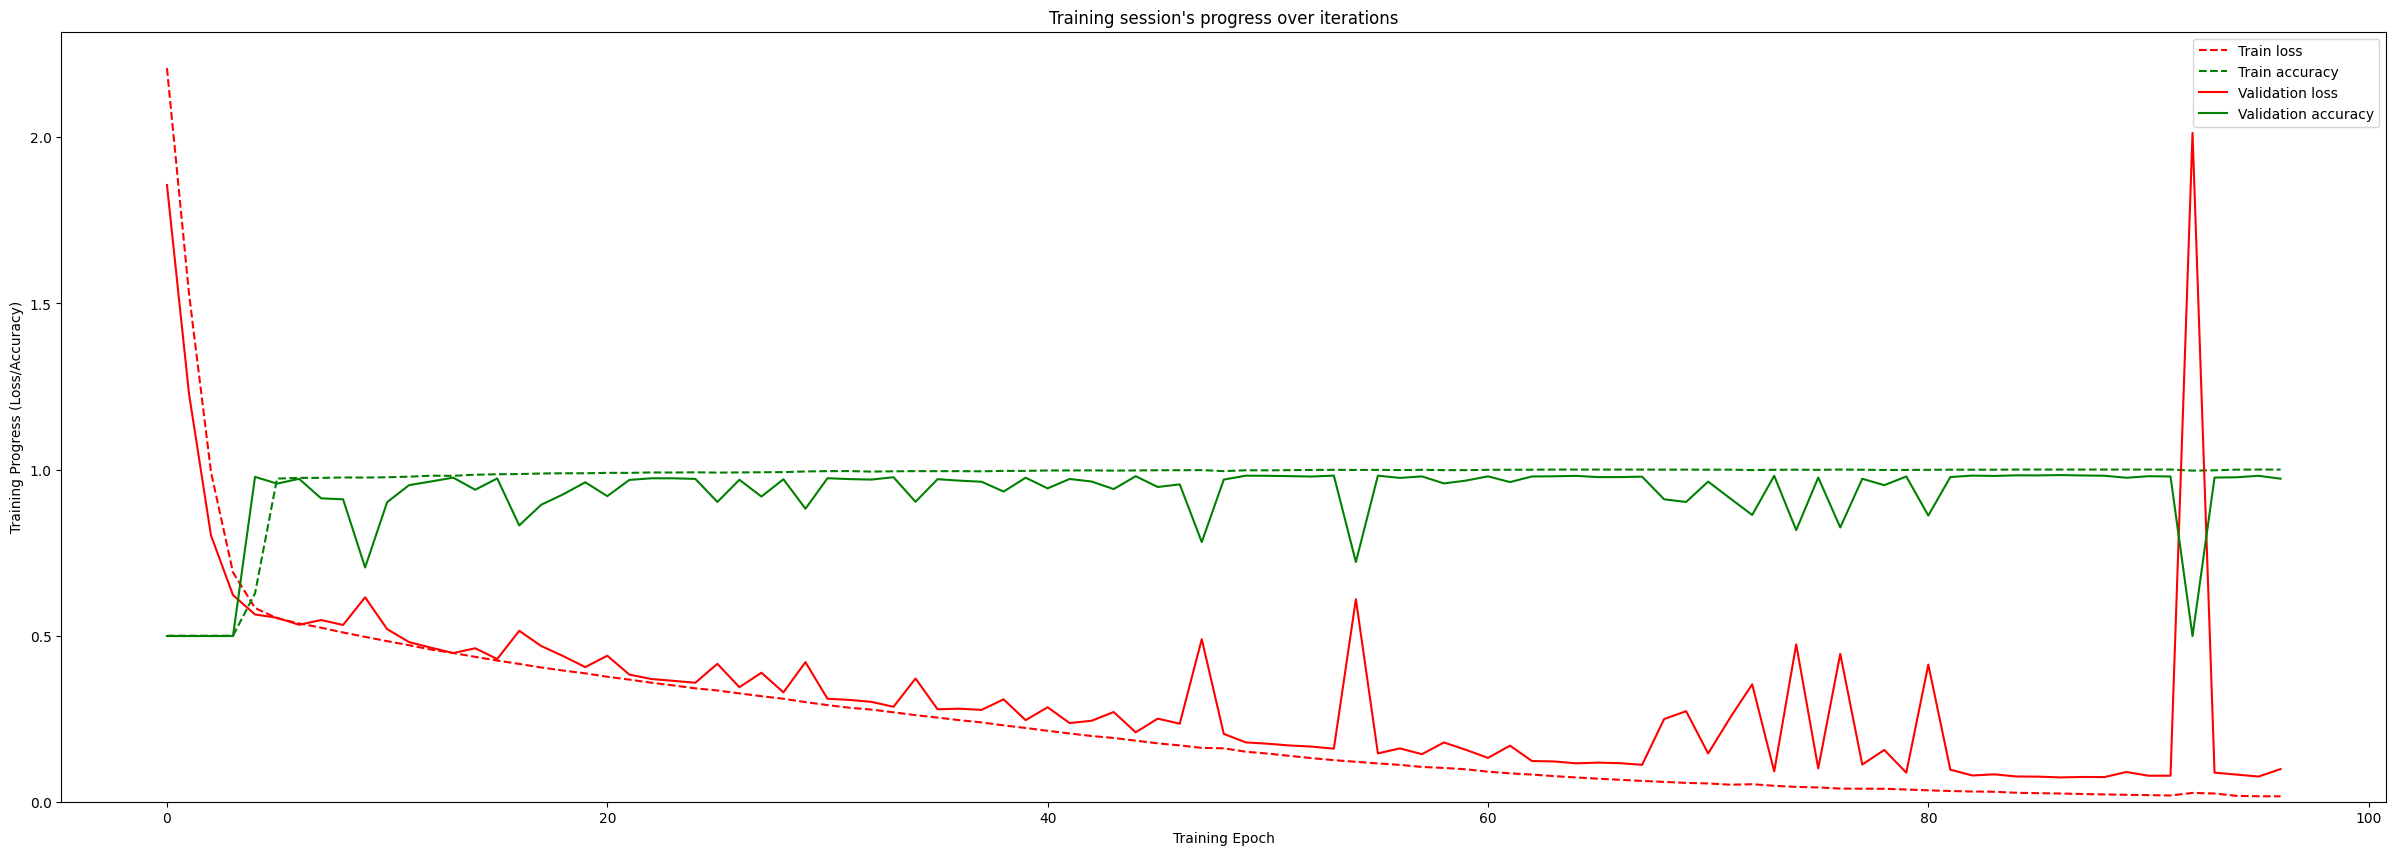

In [ ]:
visualize_training(history_tcn)

In [ ]:
save_model(f"ef_tnc_tuner_{time_step}-{size}", model_tcn)

Model: ef_tnc_tuner_4-10 was saved.


In [ ]:
evaluate_model(time_step, size, model_tcn)

Data has shape: (14764, 4, 64, 64, 3) with annotations: (14764,)
Unique annotation values: [0 1] with counts: [8873 5891]

462/462 [==============================] - 13s 27ms/step - loss: 0.1757 - accuracy: 0.9443
Evaluation Loss: 0.1757102608680725
Evaluation Accuracy: 0.9443240165710449


In [ ]:
del tuner_tcn
del best_hps_tcn
del best_hyperparameters_tcn
del model_tcn
del history_tcn
gc.collect()

413970

## LSTM

In [ ]:
tuner_lstm = create_tuner("lstm_tuner", time_step, size)

In [ ]:
tuner_lstm.search(
  data_train,
  annotations_train,
  epochs=10,
  validation_data=(data_val, annotations_val),
  callbacks=[create_callbacks("tuner")]
)

Trial 30 Complete [00h 05m 07s]
val_accuracy: 0.9359026551246643

Best val_accuracy So Far: 0.976064920425415
Total elapsed time: 01h 24m 18s


In [ ]:
best_hps_lstm = tuner_lstm.get_best_hyperparameters(num_trials=1)[0]

best_hyperparameters_lstm = tuner_lstm.get_best_hyperparameters()[0]
print("Nejlepší hyperparametry:", best_hyperparameters_lstm.values)

Nejlepší hyperparametry: {'lstm_units': 512, 'learning_rate': 0.0001, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0021'}


In [ ]:
model_lstm = tuner_lstm.hypermodel.build(best_hps_lstm)
model_lstm.summary()
history_lstm = model_lstm.fit(
  data_train,
  annotations_train,
  epochs=num_epochs,
  validation_data=(data_val, annotations_val),
  callbacks=[create_callbacks("train")]
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 4, 64, 64, 3)]    0         
                                                                 
 rescaling_2 (Rescaling)     (None, 4, 64, 64, 3)      0         
                                                                 
 lambda_2 (Lambda)           (None, 64, 64, 3)         0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 2, 2, 1280)        5919312   
 nal)                                                            
                                                                 
 lambda_3 (Lambda)           (None, 4, 5120)           0         
                                                                 
 lstm_1 (LSTM)               (None, 512)               11536384  
                                                           

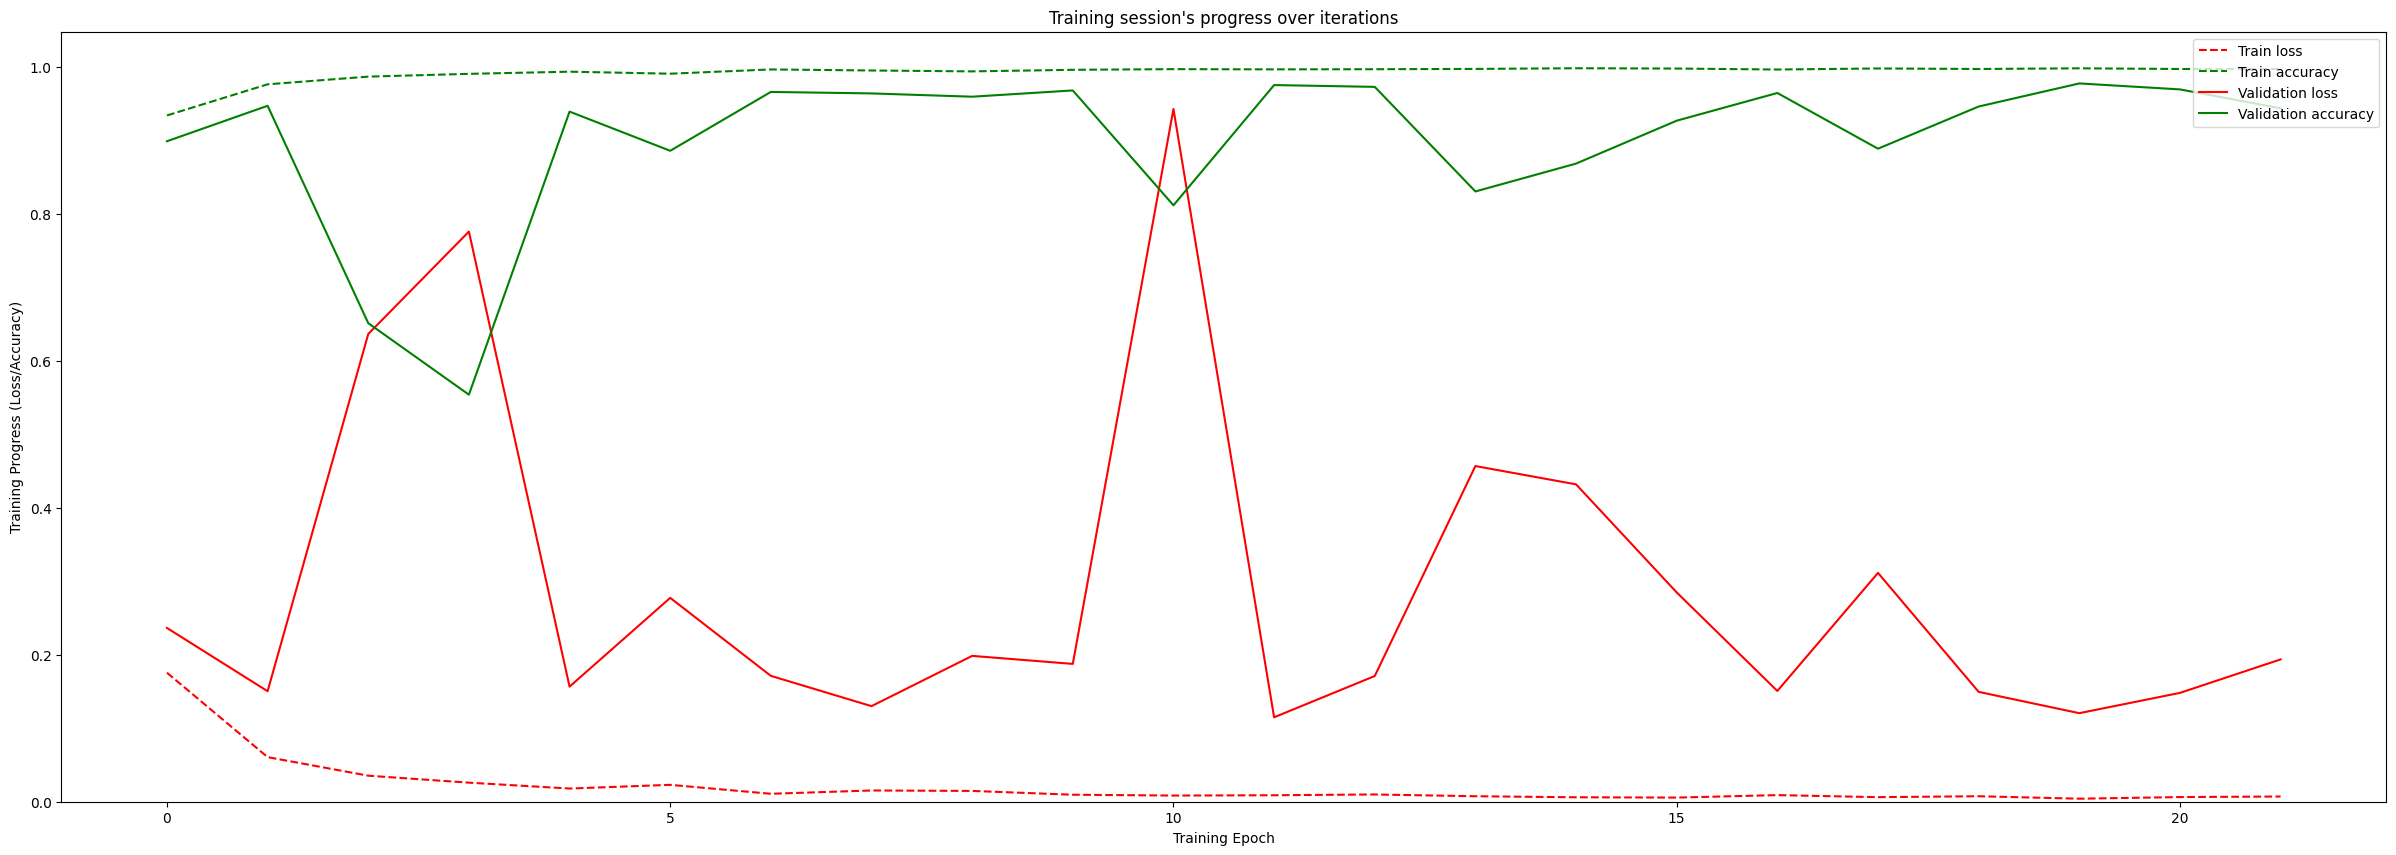

In [ ]:
visualize_training(history_lstm)

In [ ]:
save_model(f"ef_lstm_tuner_{time_step}-{size}", model_lstm)

Model: ef_lstm_tuner_4-10 was saved.


In [ ]:
evaluate_model(time_step, size, model_lstm)

Data has shape: (14764, 4, 64, 64, 3) with annotations: (14764,)
Unique annotation values: [0 1] with counts: [8873 5891]

462/462 [==============================] - 12s 26ms/step - loss: 0.3027 - accuracy: 0.9529
Evaluation Loss: 0.3026641011238098
Evaluation Accuracy: 0.9528583288192749


In [ ]:
del tuner_lstm
del best_hps_lstm
del best_hyperparameters_lstm
del model_lstm
del history_lstm
gc.collect()

419528

## Original model

In [ ]:
model_orig = define_model_efficientnet_b0(hp=None, time_steps=time_step, h=height, w=width, c=colors, tuner_type=None)
history_orig = train_model(model_orig, x_train=data_train, y_train=annotations_train,
                      x_val=data_val, y_val=annotations_val, epochs=num_epochs,
                      callbacks=[create_callbacks("train")], learning_rate=learning_rate
                      )

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 4, 64, 64, 3)]    0         
                                                                 
 rescaling_6 (Rescaling)     (None, 4, 64, 64, 3)      0         
                                                                 
 lambda_6 (Lambda)           (None, 64, 64, 3)         0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 2, 2, 1280)        5919312   
 nal)                                                            
                                                                 
 lambda_7 (Lambda)           (None, 4, 5120)           0         
                                                                 
 tcn_3 (TCN)                 (None, 6)                 154362    
                                                           

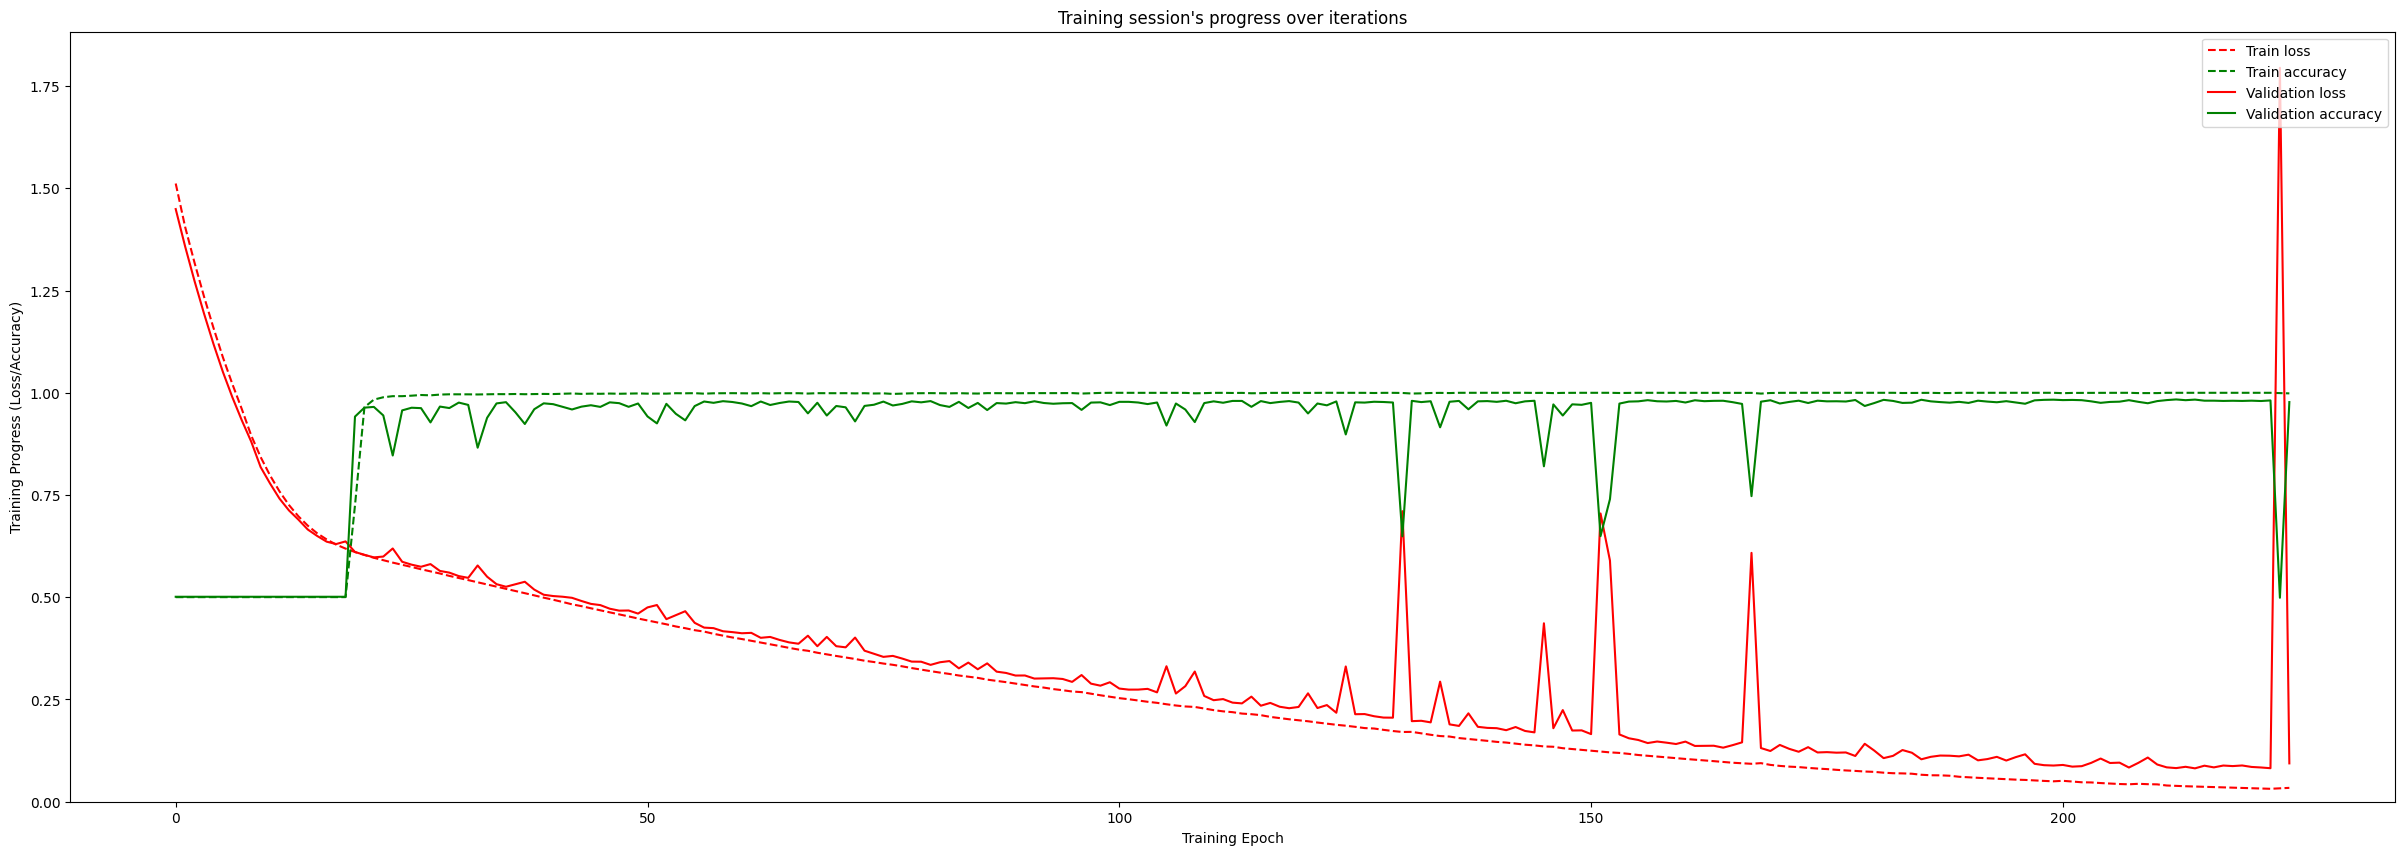

In [ ]:
visualize_training(history_orig)

In [ ]:
save_model(f"ef_tnc_{time_step}-{size}", model_orig)

Model: ef_tnc_4-10 was saved.


In [ ]:
evaluate_model(time_step, size, model_orig)

Data has shape: (14764, 4, 64, 64, 3) with annotations: (14764,)
Unique annotation values: [0 1] with counts: [8873 5891]

462/462 [==============================] - 12s 25ms/step - loss: 0.1615 - accuracy: 0.9555
Evaluation Loss: 0.16152046620845795
Evaluation Accuracy: 0.9554998874664307


In [ ]:
del model_orig
del history_orig
gc.collect()

425448

# Model 2_8
- Size of the series: 2
- Images before/after emerged: 8

In [ ]:
time_step = 2
size = 8

data_train, annotations_train = load_data_npy(
  base_path=data_images_path, time_step=time_step, use_trays=trays_train, size=size
)

data_val, annotations_val = load_data_npy(
  base_path=data_images_path, time_step=time_step, use_trays=trays_val, size=size
)

Data has shape: (9825, 2, 64, 64, 3) with annotations: (9825,)
Unique annotation values: [0 1] with counts: [4914 4911]

Data has shape: (4935, 2, 64, 64, 3) with annotations: (4935,)
Unique annotation values: [0 1] with counts: [2471 2464]



## TCN

In [ ]:
tuner_tcn = create_tuner("tcn_tuner", time_step, size)

In [ ]:
tuner_tcn.search(
  data_train,
  annotations_train,
  epochs=10,
  validation_data=(data_val, annotations_val),
  callbacks=[create_callbacks("tuner")]
)

Trial 30 Complete [00h 03m 05s]
val_accuracy: 0.6875379681587219

Best val_accuracy So Far: 0.9621074199676514
Total elapsed time: 01h 10m 53s


In [ ]:
best_hps_tcn = tuner_tcn.get_best_hyperparameters(num_trials=1)[0]

best_hyperparameters_tcn = tuner_tcn.get_best_hyperparameters()[0]
print("Nejlepší hyperparametry:", best_hyperparameters_tcn.values)

Nejlepší hyperparametry: {'nb_filters': 16, 'kernel_size': 3, 'dropout_rate': 0.0, 'nb_stacks': 1, 'learning_rate': 0.0001, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0018'}


In [ ]:
model_tcn = tuner_tcn.hypermodel.build(best_hps_tcn)
model_tcn.summary()
history_tcn = model_tcn.fit(
  data_train,
  annotations_train,
  epochs=num_epochs,
  validation_data=(data_val, annotations_val),
  callbacks=[create_callbacks("train")]
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2, 64, 64, 3)]    0         
                                                                 
 rescaling_2 (Rescaling)     (None, 2, 64, 64, 3)      0         
                                                                 
 lambda_2 (Lambda)           (None, 64, 64, 3)         0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 2, 2, 1280)        5919312   
 nal)                                                            
                                                                 
 lambda_3 (Lambda)           (None, 2, 5120)           0         
                                                                 
 tcn_1 (TCN)                 (None, 16)                331632    
                                                           

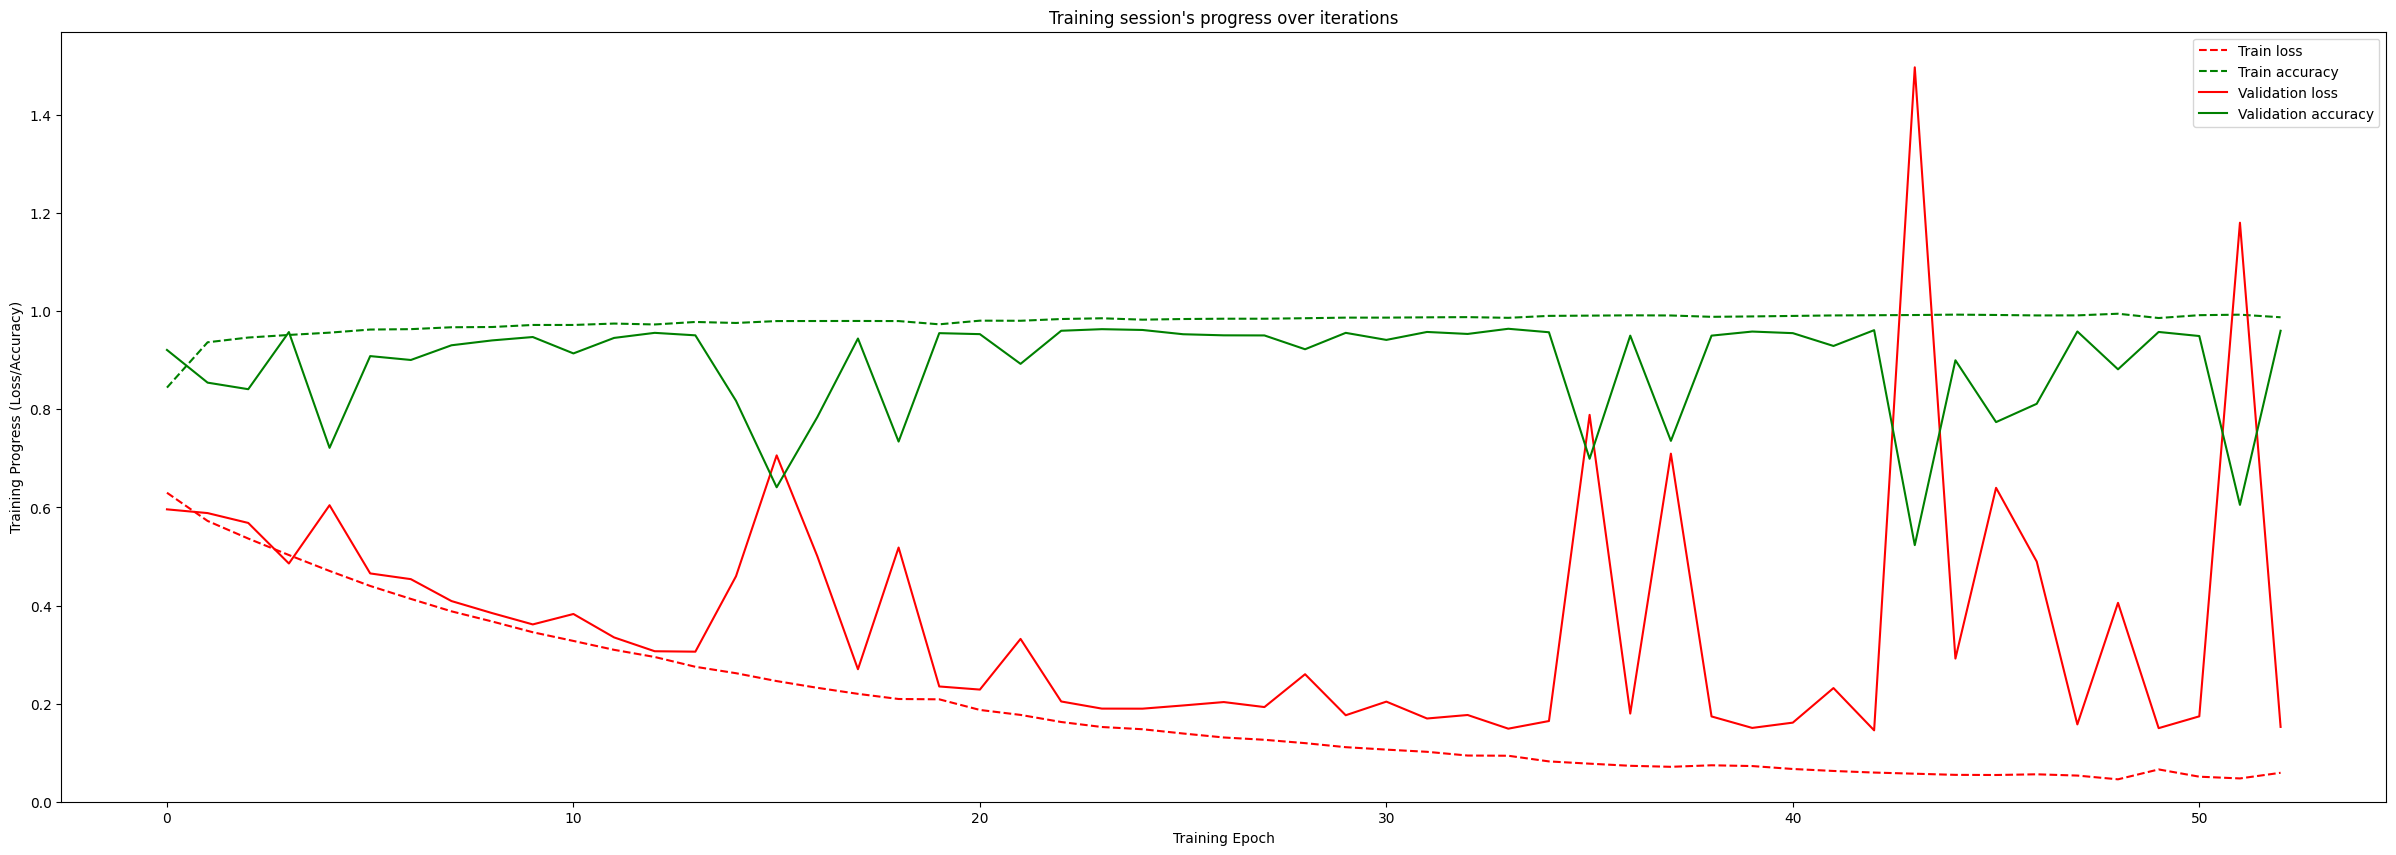

In [ ]:
visualize_training(history_tcn)

In [ ]:
save_model(f"ef_tnc_tuner_{time_step}-{size}", model_tcn)

Model: ef_tnc_tuner_2-8 was saved.


In [ ]:
evaluate_model(time_step, size, model_tcn)

Data has shape: (14766, 2, 64, 64, 3) with annotations: (14766,)
Unique annotation values: [0 1] with counts: [8873 5893]

462/462 [==============================] - 8s 18ms/step - loss: 0.1378 - accuracy: 0.9584
Evaluation Loss: 0.1378110945224762
Evaluation Accuracy: 0.9584180116653442


In [ ]:
del tuner_tcn
del best_hps_tcn
del best_hyperparameters_tcn
del model_tcn
del history_tcn
gc.collect()

400977

## LSTM

In [ ]:
tuner_lstm = create_tuner("lstm_tuner", time_step, size)

In [ ]:
tuner_lstm.search(
  data_train,
  annotations_train,
  epochs=10,
  validation_data=(data_val, annotations_val),
  callbacks=[create_callbacks("tuner")]
)

Trial 30 Complete [00h 03m 43s]
val_accuracy: 0.7892603874206543

Best val_accuracy So Far: 0.9533941149711609
Total elapsed time: 01h 07m 44s


In [ ]:
best_hps_lstm = tuner_lstm.get_best_hyperparameters(num_trials=1)[0]

best_hyperparameters_lstm = tuner_lstm.get_best_hyperparameters()[0]
print("Nejlepší hyperparametry:", best_hyperparameters_lstm.values)

Nejlepší hyperparametry: {'lstm_units': 512, 'learning_rate': 0.0001, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0023'}


In [ ]:
model_lstm = tuner_lstm.hypermodel.build(best_hps_lstm)
model_lstm.summary()
history_lstm = model_lstm.fit(
  data_train,
  annotations_train,
  epochs=num_epochs,
  validation_data=(data_val, annotations_val),
  callbacks=[create_callbacks("train")]
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2, 64, 64, 3)]    0         
                                                                 
 rescaling_2 (Rescaling)     (None, 2, 64, 64, 3)      0         
                                                                 
 lambda_2 (Lambda)           (None, 64, 64, 3)         0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 2, 2, 1280)        5919312   
 nal)                                                            
                                                                 
 lambda_3 (Lambda)           (None, 2, 5120)           0         
                                                                 
 lstm_1 (LSTM)               (None, 512)               11536384  
                                                           

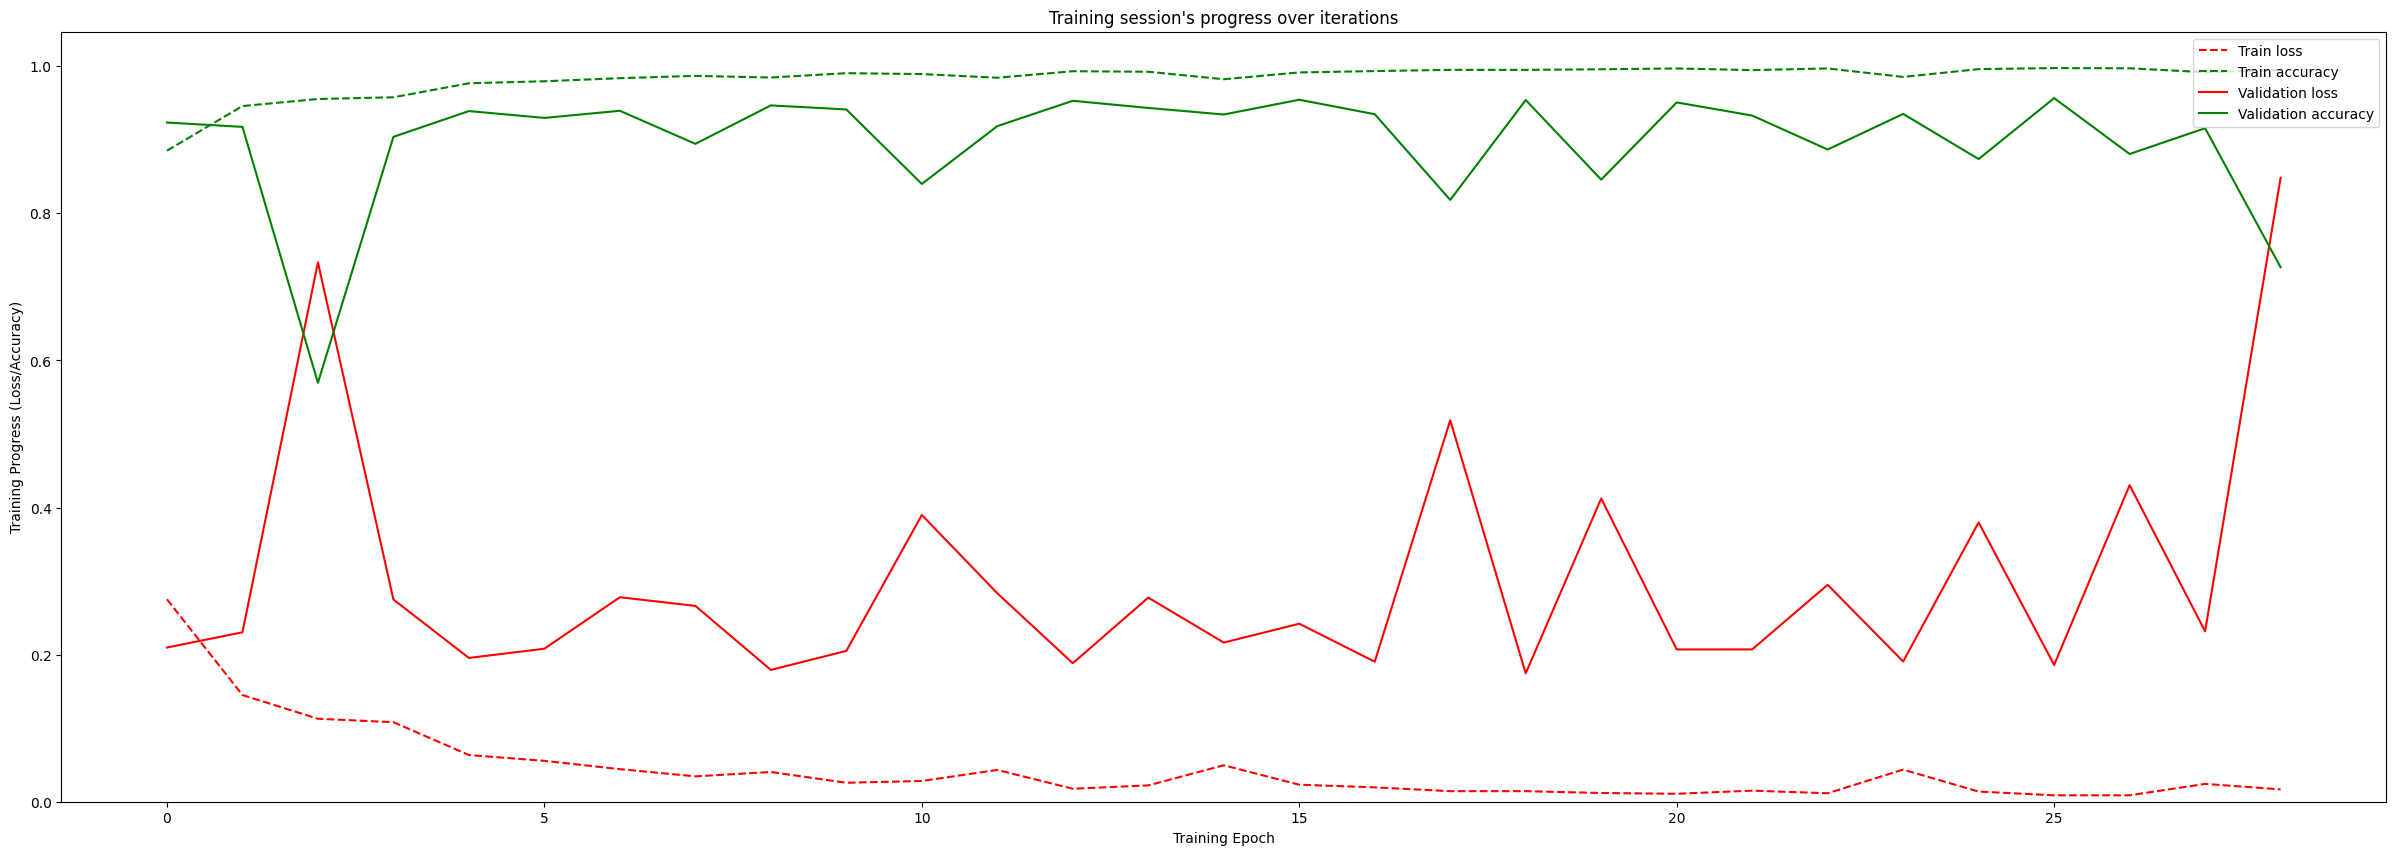

In [ ]:
visualize_training(history_lstm)

In [ ]:
save_model(f"ef_lstm_tuner_{time_step}-{size}", model_lstm)

Model: ef_lstm_tuner_2-8 was saved.


In [ ]:
evaluate_model(time_step, size, model_lstm)

Data has shape: (14766, 2, 64, 64, 3) with annotations: (14766,)
Unique annotation values: [0 1] with counts: [8873 5893]

462/462 [==============================] - 8s 17ms/step - loss: 0.2373 - accuracy: 0.9497
Evaluation Loss: 0.23729708790779114
Evaluation Accuracy: 0.9496816992759705


In [ ]:
del tuner_lstm
del best_hps_lstm
del best_hyperparameters_lstm
del model_lstm
del history_lstm
gc.collect()

419751

## Original model

In [ ]:
model_orig = define_model_efficientnet_b0(hp=None, time_steps=time_step, h=height, w=width, c=colors, tuner_type=None)
history_orig = train_model(model_orig, x_train=data_train, y_train=annotations_train,
                      x_val=data_val, y_val=annotations_val, epochs=num_epochs,
                      callbacks=[create_callbacks("train")], learning_rate=learning_rate
                      )

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 2, 64, 64, 3)]    0         
                                                                 
 rescaling_4 (Rescaling)     (None, 2, 64, 64, 3)      0         
                                                                 
 lambda_4 (Lambda)           (None, 64, 64, 3)         0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 2, 2, 1280)        5919312   
 nal)                                                            
                                                                 
 lambda_5 (Lambda)           (None, 2, 5120)           0         
                                                                 
 tcn (TCN)                   (None, 6)                 154362    
                                                           

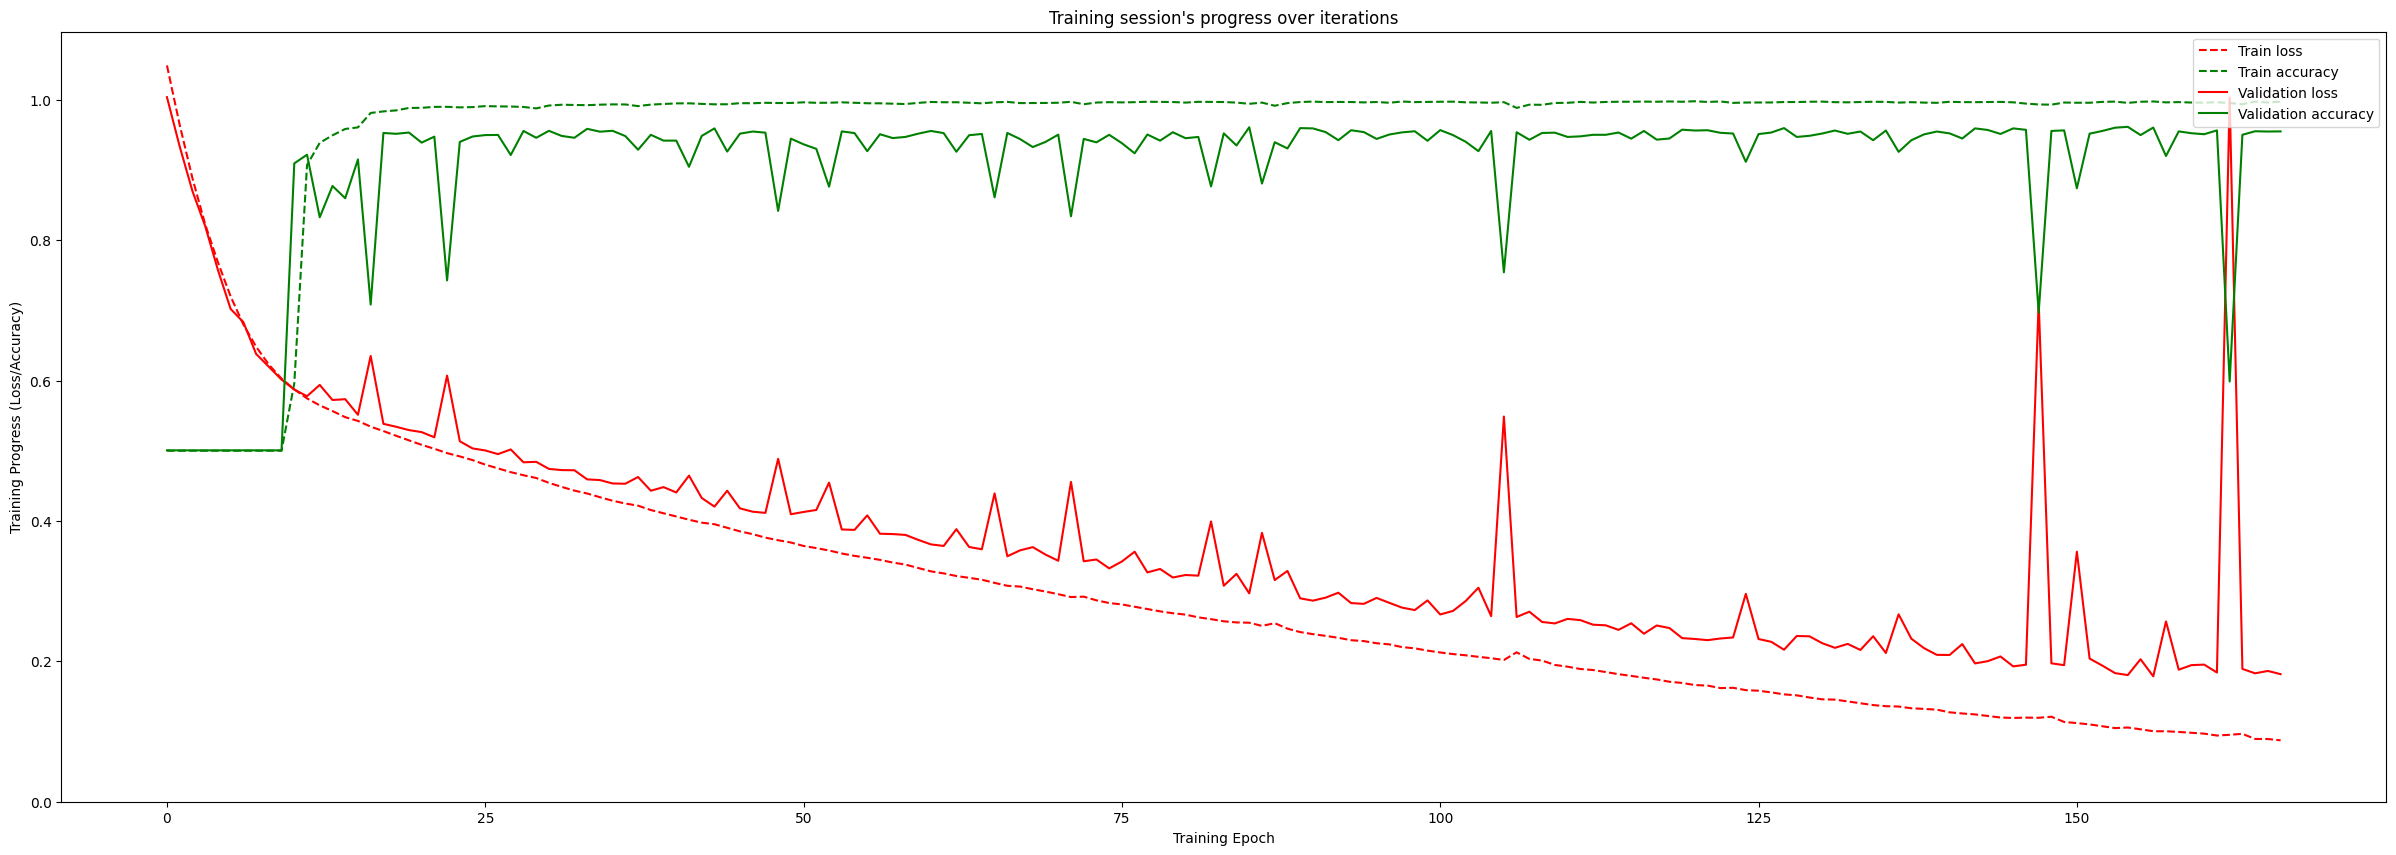

In [ ]:
visualize_training(history_orig)

In [ ]:
save_model(f"ef_tnc_{time_step}-{size}", model_orig)

Model: ef_tnc_2-8 was saved.


In [ ]:
evaluate_model(time_step, size, model_orig)

Data has shape: (14766, 2, 64, 64, 3) with annotations: (14766,)
Unique annotation values: [0 1] with counts: [8873 5893]

462/462 [==============================] - 7s 16ms/step - loss: 0.1755 - accuracy: 0.9525
Evaluation Loss: 0.17546044290065765
Evaluation Accuracy: 0.9525260925292969


In [ ]:
del model_orig
del history_orig
gc.collect()

395109